<a href="https://colab.research.google.com/github/RaviKiran-494/Exercise/blob/main/LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

Loading LFW Dataset

In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.4)

Extracting images and labes

In [ ]:
X = lfw_people.images
y = lfw_people.target
target_names = lfw_people.target_names

Flattening


In [ ]:
n_samples, h, w = X.shape
X_flattened = X.reshape(n_samples, h * w)

Splitting the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.3, random_state=42, stratify=y)

------------------- Using Inbuilt Fuction --------------------

Applying LDA

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=min(len(target_names) - 1, X_train.shape[1]))
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

SVM Classifier

In [ ]:
clf = SVC(kernel='linear', random_state=42)
clf.fit(X_train_lda, y_train)

SVC(kernel='linear', random_state=42)

Prediction

In [ ]:
y_pred = clf.predict(X_test_lda)

Showning Accuracy

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names))

Accuracy: 0.7660818713450293
                   precision    recall  f1-score   support

     Colin Powell       0.72      0.65      0.68        71
  Donald Rumsfeld       0.63      0.72      0.68        36
    George W Bush       0.82      0.83      0.83       159
Gerhard Schroeder       0.79      0.82      0.81        33
       Tony Blair       0.72      0.72      0.72        43

         accuracy                           0.77       342
        macro avg       0.74      0.75      0.74       342
     weighted avg       0.77      0.77      0.77       342



Plotting LDA projrction of LFW data

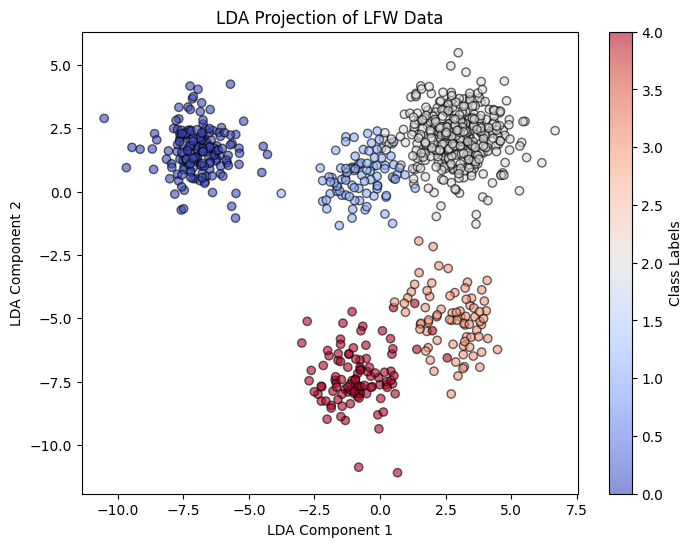

In [ ]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_lda[:, 0], X_train_lda[:, 1], c=y_train, cmap='coolwarm', edgecolors='k', alpha=0.6)
plt.title("LDA Projection of LFW Data")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.colorbar(label="Class Labels")
plt.show()

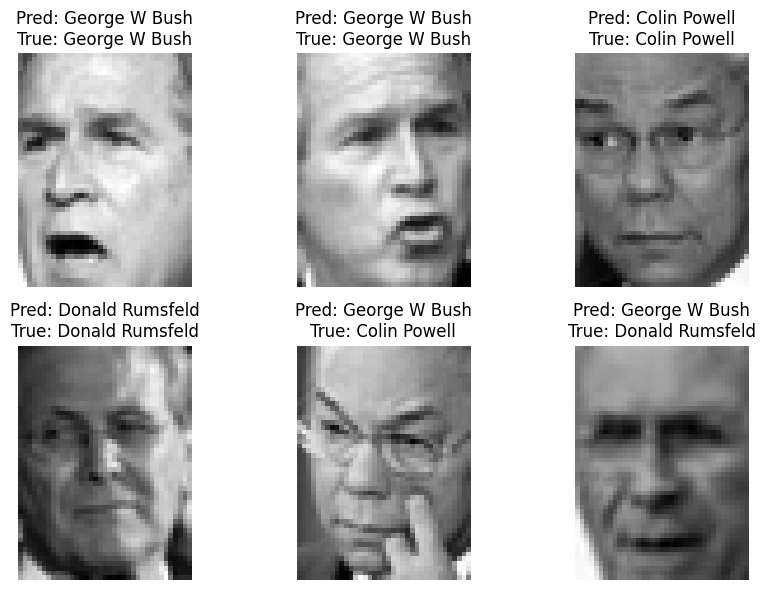

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].reshape(h, w), cmap="gray")
    ax.set_title(f"Pred: {target_names[y_pred[i]]}\nTrue: {target_names[y_test[i]]}")
    ax.axis("off")

plt.tight_layout()
plt.show()


-----------------  Checking for different classifiers ------------------------

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
classifiers = [
    SVC(kernel='linear', random_state=42),
    KNeighborsClassifier(n_neighbors=5),
    RandomForestClassifier(random_state=42),
    GaussianNB(),
    LogisticRegression(random_state=42),
    DecisionTreeClassifier(random_state=42)
]

classifier_names = ["SVM", "KNN", "Random Forest", "Naive Bayes", "Logistic Regression", "Decision Tree"]


In [ ]:
accuracy_scores = []

# Loop through each classifier
for clf, name in zip(classifiers, classifier_names):
    clf.fit(X_train_lda, y_train)
    y_pred = clf.predict(X_test_lda)
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)
    print(f"{name} Accuracy: {acc:.4f}")


SVM Accuracy: 0.7661
KNN Accuracy: 0.7749
Random Forest Accuracy: 0.7105
Naive Bayes Accuracy: 0.7690
Logistic Regression Accuracy: 0.7719
Decision Tree Accuracy: 0.7018


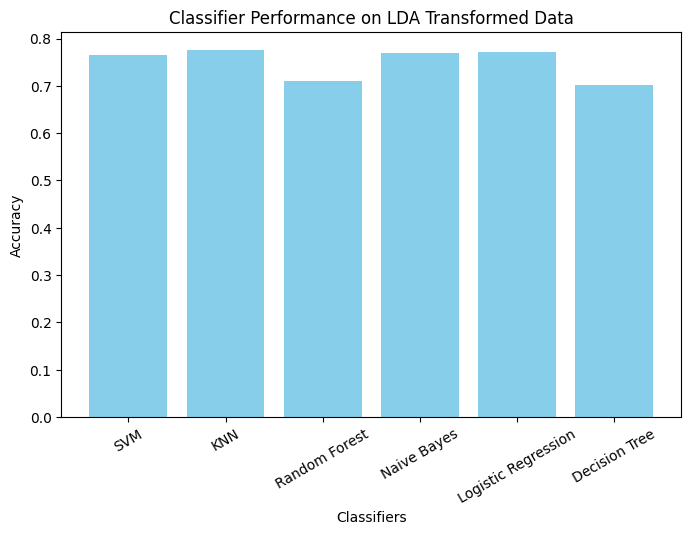

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(classifier_names, accuracy_scores, color='skyblue')
plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.title("Classifier Performance on LDA Transformed Data")
plt.xticks(rotation=30)
plt.show()


---------------- Mathematically ----------------

Calculating Mean of dataset

In [ ]:
mean_overall = np.mean(X_train, axis=0)

Computing the mean of classes

In [ ]:
num_classes = len(target_names)
S_W = np.zeros((X_train.shape[1], X_train.shape[1]))
S_B = np.zeros((X_train.shape[1], X_train.shape[1]))

for c in np.unique(y_train):
    X_c = X_train[y_train == c]  # Extract all samples of class c
    mean_c = np.mean(X_c, axis=0)  # Compute class mean
    S_W += np.dot((X_c - mean_c).T, (X_c - mean_c))  # Sum of covariance for class c
    n_c = X_c.shape[0]  # Number of samples in class c
    mean_diff = (mean_c - mean_overall).reshape(-1, 1)
    S_B += n_c * np.dot(mean_diff, mean_diff.T)  # Contribution to between-class scatter

In [ ]:
reg_param = 1e-5  # Small regularization parameter
S_W += reg_param * np.eye(S_W.shape[0])  # Adding small identity matrix


Solving the generalized eigenvalue problem for S_W⁻¹ S_B

In [ ]:
eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(S_W) @ S_B)



 Sorting eigenvectors by decreasing eigenvalues


In [ ]:
sorted_indices = np.argsort(-eigvals.real)
eigvecs = eigvecs[:, sorted_indices]

Selecting the  top LDA components

In [ ]:
num_lda_components = min(num_classes - 1, X_train.shape[1])
W = eigvecs[:, :num_lda_components].real

In [ ]:
X_train_lda = X_train @ W
X_test_lda = X_test @ W

In [ ]:
clf = SVC(kernel='rbf', C=100, gamma='scale', random_state=42)
clf.fit(X_train_lda, y_train)


SVC(C=100, random_state=42)

In [ ]:
y_pred = clf.predict(X_test_lda)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names))

Accuracy: 0.16666666666666666
                   precision    recall  f1-score   support

     Colin Powell       0.23      0.25      0.24        71
  Donald Rumsfeld       0.15      0.42      0.22        36
    George W Bush       1.00      0.01      0.01       159
Gerhard Schroeder       0.14      0.30      0.19        33
       Tony Blair       0.14      0.30      0.19        43

         accuracy                           0.17       342
        macro avg       0.33      0.26      0.17       342
     weighted avg       0.56      0.17      0.12       342



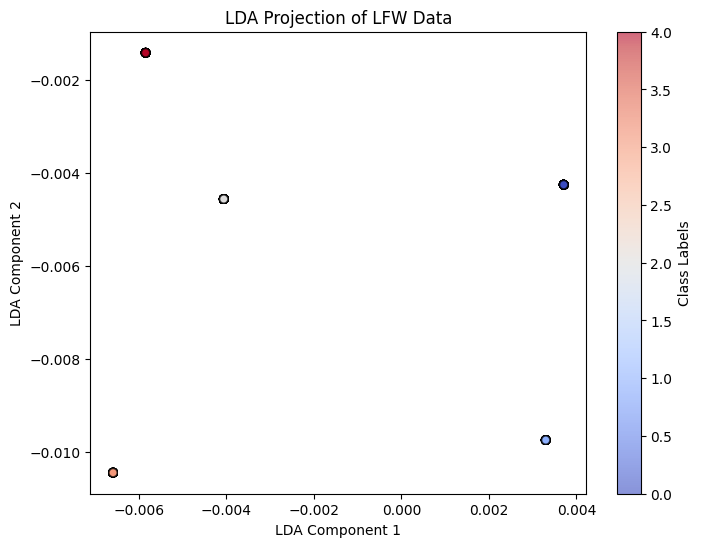

In [ ]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_lda[:, 0], X_train_lda[:, 1], c=y_train, cmap='coolwarm', edgecolors='k', alpha=0.6)
plt.title("LDA Projection of LFW Data")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.colorbar(label="Class Labels")
plt.show()


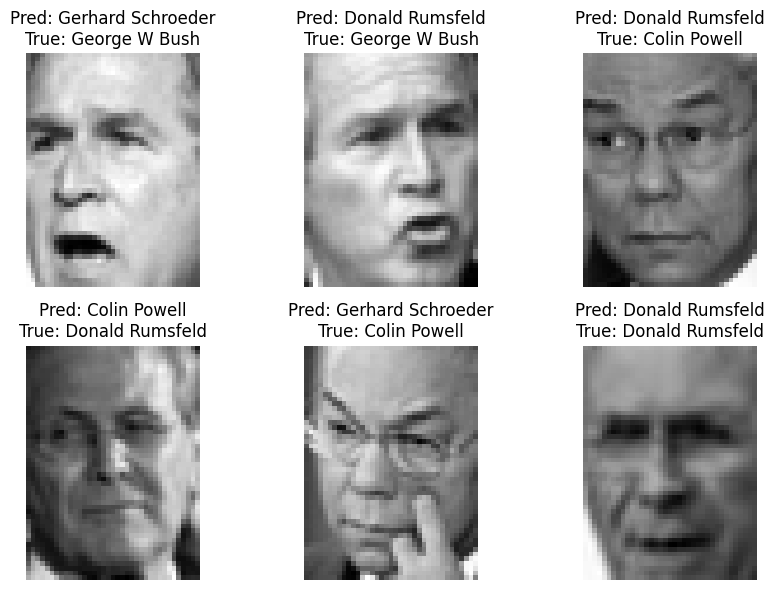

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].reshape(h, w), cmap="gray")
    ax.set_title(f"Pred: {target_names[y_pred[i]]}\nTrue: {target_names[y_test[i]]}")
    ax.axis("off")

plt.tight_layout()
plt.show()


-------------- checking for different classifiers ----------------------

In [ ]:
classifiers = [
    SVC(kernel='linear', random_state=42),
    KNeighborsClassifier(n_neighbors=5),
    RandomForestClassifier(random_state=42),
    GaussianNB(),
    LogisticRegression(random_state=42),
    DecisionTreeClassifier(random_state=42)
]

classifier_names = ["SVM", "KNN", "Random Forest", "Naive Bayes", "Logistic Regression", "Decision Tree"]


SVM Accuracy: 0.4649
KNN Accuracy: 0.1667
Random Forest Accuracy: 0.1462
Naive Bayes Accuracy: 0.1988
Logistic Regression Accuracy: 0.4649
Decision Tree Accuracy: 0.1257


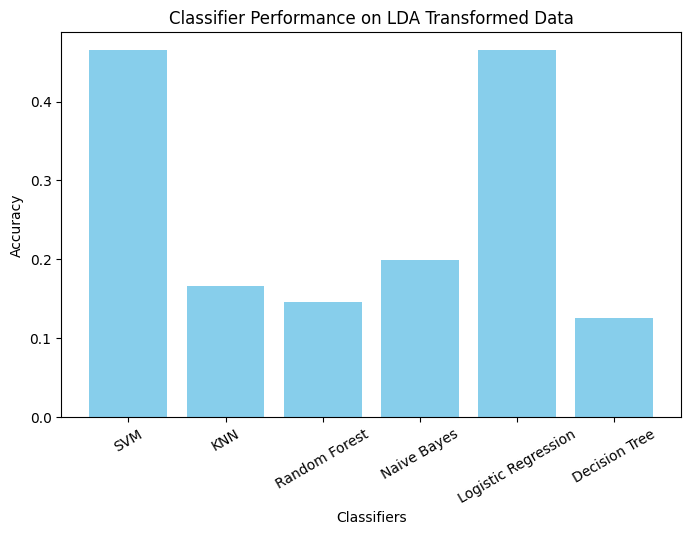

In [ ]:
accuracy_scores = []

# Loop through each classifier
for clf, name in zip(classifiers, classifier_names):
    clf.fit(X_train_lda, y_train)
    y_pred = clf.predict(X_test_lda)
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)
    print(f"{name} Accuracy: {acc:.4f}")

# Plotting bar graph
plt.figure(figsize=(8, 5))
plt.bar(classifier_names, accuracy_scores, color='skyblue')
plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.title("Classifier Performance on LDA Transformed Data")
plt.xticks(rotation=30)
plt.show()